# FloPy

## Making Maps and Cross-Sections of Your Model
This notebook demonstrates the mapping and cross-section capabilities of flopy.  It demonstrates these capabilities by loading and running an existing model, and then showing how the ModelMap and ModelCrossSection objects, and their methods can be used to make nice plots of the model grid, boundary conditions, models results, shape files, etc.


In [1]:
%matplotlib inline
import sys
import os
import platform
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.6.0 |Anaconda 4.3.0 (x86_64)| (default, Dec 23 2016, 13:19:00) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
numpy version: 1.11.3
matplotlib version: 2.0.0
flopy version: 3.2.6


In [2]:
#Set name of MODFLOW exe
#  assumes executable is in users path statement
version = 'mf2005'
exe_name = 'mf2005'
exe_mp = 'mp6'
if platform.system() == 'Windows':
    exe_name += '.exe'
    exe_mp += '.exe'
mfexe = exe_name

#Set the paths
loadpth = os.path.join('..', 'data', 'freyberg')
modelpth = os.path.join('data')

#make sure modelpth directory exists
if not os.path.exists(modelpth):
    os.makedirs(modelpth)

### Load and Run an Existing Model
A model called the "Freyberg Model" is located in the loadpth folder.  In the following code block, we load that model, then change into a new workspace (modelpth) where we recreate and run the model.  For this to work properly, the MODFLOW-2005 executable (mf2005) must be in the path.  We verify that it worked correctly by checking for the presence of freyberg.hds and freyberg.cbc.

In [3]:
ml = flopy.modflow.Modflow.load('freyberg.nam', model_ws=loadpth, 
                                exe_name=exe_name, version=version)
ml.change_model_ws(new_pth=modelpth)
ml.write_input()
success, buff = ml.run_model()
if not success:
    print ('Something bad happened.')
files = ['freyberg.hds', 'freyberg.cbc']
for f in files:
    if os.path.isfile(os.path.join(modelpth, f)):
        msg = 'Output file located: {}'.format(f)
        print (msg)
    else:
        errmsg = 'Error. Output file cannot be found: {}'.format(f)
        print (errmsg)


changing model workspace...
   data
FloPy is using the following executable to run the model: /Users/JosephHughes/USGS/Development/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2017/03/18 19:40:27

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2017/03/18 19:40:27
 Elapsed run time:  0.033 Seconds

  Normal termination of simulation
Output file located: freyberg.hds
Output file located: freyberg.cbc


### Create and Run MODPATH 6 model

The MODFLOW model created in the previous code block will be used to create a endpoint capture zone and pathline analysis for the pumping wells in the model.

In [4]:
mp = flopy.modpath.Modpath('freybergmp', exe_name=exe_mp, modflowmodel=ml, model_ws=modelpth)
mpbas = flopy.modpath.ModpathBas(mp, hnoflo=ml.bas6.hnoflo, hdry=ml.lpf.hdry, 
                                 ibound=ml.bas6.ibound.array, prsity=0.2, prsityCB=0.2)
sim = mp.create_mpsim(trackdir='forward', simtype='endpoint', packages='RCH')
mp.write_input()
mp.run_model()

mpp = flopy.modpath.Modpath('freybergmpp', exe_name=exe_mp, modflowmodel=ml, model_ws=modelpth)
mpbas = flopy.modpath.ModpathBas(mpp, hnoflo=ml.bas6.hnoflo, hdry=ml.lpf.hdry, 
                                 ibound=ml.bas6.ibound.array, prsity=0.2, prsityCB=0.2)
sim = mpp.create_mpsim(trackdir='backward', simtype='pathline', packages='WEL')
mpp.write_input()
mpp.run_model()

FloPy is using the following executable to run the model: /Users/JosephHughes/Development/bin/mp6
Processing basic data ...
Checking head file ...
Checking budget file and building index ...

Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+01                                                                       
Particle tracking complete. Writing endpoint file ...                                                                               
End of MODPATH simulation. Normal termination.
FloPy is using the following executable to run the model: /Users/JosephHughes/Development/bin/mp6
Processing basic data ...
Checking head file ...
Checking budget file and building index ...

Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+01                                                                       
Particle tracking complete. Writing endpoint file ...                                           

(True, [])

### Creating a Map and Cross-Section of the Model Grid
Now that we have a model, we can use the flopy plotting utilities to make maps and cross-sections.  We will start by making a map of the model grid using the ModelMap class and the plot_grid method of that class.

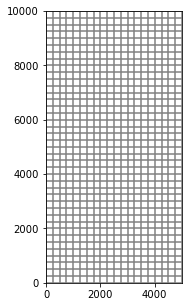

In [5]:
# First step is to set up the plot
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

# Next we create an instance of the ModelMap class
modelmap = flopy.plot.ModelMap(sr=ml.dis.sr)

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
linecollection = modelmap.plot_grid()

Next we will make a cross-section of the model grid at column 6.

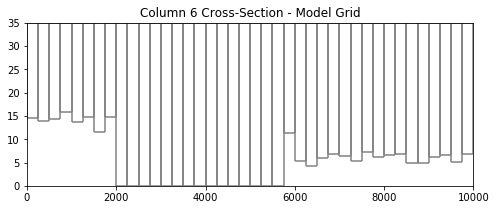

In [6]:
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(1, 1, 1)

# Next we create an instance of the ModelCrossSection class
modelxsect = flopy.plot.ModelCrossSection(model=ml, line={'Column': 5})

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
linecollection = modelxsect.plot_grid()
t = ax.set_title('Column 6 Cross-Section - Model Grid')

The ModelMap instance can be created using several different keyword arguments to position the model grid in space.  The three keywords are: xul, yul, and rotation.  The values represent the x-coordinate of the upper left corner, the y-coordinate of the upper-left coordinate, and the rotation angle (in degrees) of the upper left coordinate.  If these values are not specified, then they default to model coordinates.

Here we demonstrate the effects of these values.  In the first two plots, the grid origin (upper left corner) remains fixed at (0, 10000).  The y-value of 10000 is the sum of the model delc array (a sum of all the row heights).

/Users/JosephHughes/Development/flopy-git/flopy/utils/reference.py:404: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)
/Users/JosephHughes/Development/flopy-git/flopy/utils/reference.py:278: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)


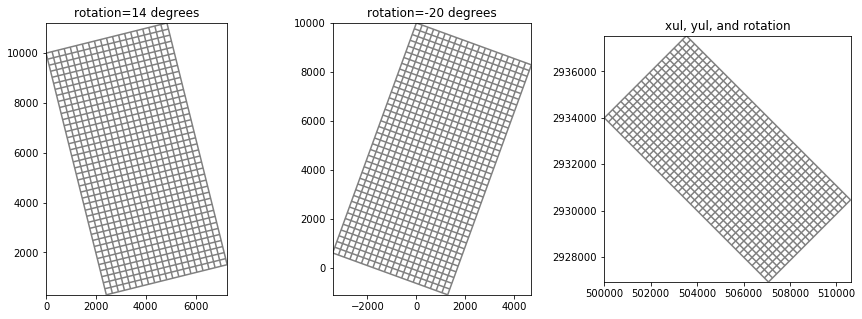

In [7]:
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(1, 3, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=ml, rotation=14)
linecollection = modelmap.plot_grid()
t = ax.set_title('rotation=14 degrees')

ax = fig.add_subplot(1, 3, 2, aspect='equal')
modelmap = flopy.plot.ModelMap(model=ml, rotation=-20)
linecollection = modelmap.plot_grid()
t = ax.set_title('rotation=-20 degrees')

ax = fig.add_subplot(1, 3, 3, aspect='equal')
modelmap = flopy.plot.ModelMap(model=ml, xul=500000, yul=2934000, rotation=45)
linecollection = modelmap.plot_grid()
t = ax.set_title('xul, yul, and rotation')

###Ploting Ibound
The plot_ibound() method can be used to plot the boundary conditions contained in the ibound arrray, which is part of the MODFLOW Basic Package.  The plot_ibound() method returns a matplotlib QuadMesh object (matplotlib.collections.QuadMesh).  If you are familiar with the matplotlib collections, then this may be important to you, but if not, then don't worry about the return objects of these plotting function.

/Users/JosephHughes/Development/flopy-git/flopy/utils/reference.py:404: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)
/Users/JosephHughes/Development/flopy-git/flopy/utils/reference.py:278: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)


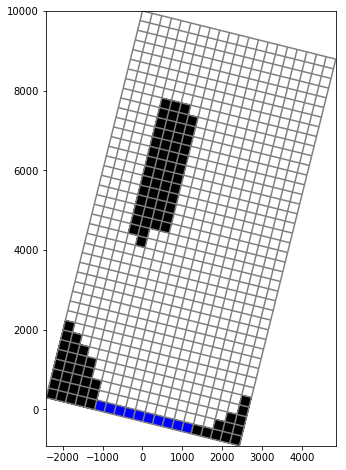

In [8]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=ml, rotation=-14)
quadmesh = modelmap.plot_ibound()
linecollection = modelmap.plot_grid()

/Users/JosephHughes/Development/flopy-git/flopy/utils/reference.py:404: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)
/Users/JosephHughes/Development/flopy-git/flopy/utils/reference.py:278: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)


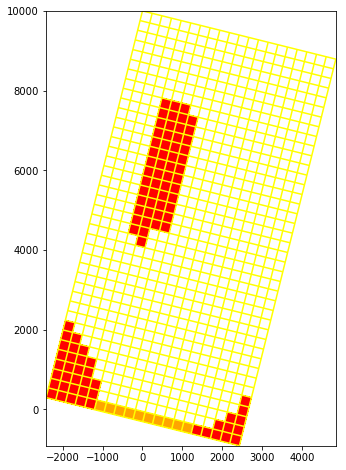

In [9]:
# Or we could change the colors!
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=ml, rotation=-14)
quadmesh = modelmap.plot_ibound(color_noflow='red', color_ch='orange')
linecollection = modelmap.plot_grid(colors='yellow')

The plot_ibound() method can be used to plot a cross-section of the boundary conditions contained in the ibound arrray, which is part of the MODFLOW Basic Package.  The plot_ibound() method returns a matplotlib Patch object (matplotlib.collections.PatchCollection).

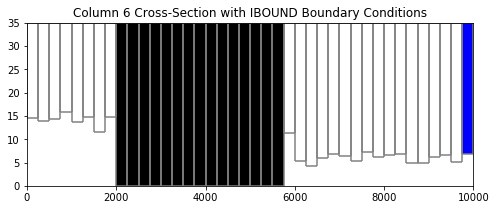

In [10]:
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(1, 1, 1)
modelxsect = flopy.plot.ModelCrossSection(model=ml, line={'Column': 5})
patches = modelxsect.plot_ibound()
linecollection = modelxsect.plot_grid()
t = ax.set_title('Column 6 Cross-Section with IBOUND Boundary Conditions')

### Plotting Boundary Conditions
The plot_bc() method can be used to plot boundary conditions.  It is setup to use the following dictionary to assign colors, however, these colors can be changed in the method call.

    bc_color_dict = {'default': 'black', 'WEL': 'red', 'DRN': 'yellow',
                 'RIV': 'green', 'GHB': 'cyan', 'CHD': 'navy'}

Here, we plot the location of river cells and the location of well cells.

/Users/JosephHughes/Development/flopy-git/flopy/utils/reference.py:404: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)
/Users/JosephHughes/Development/flopy-git/flopy/utils/reference.py:278: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)


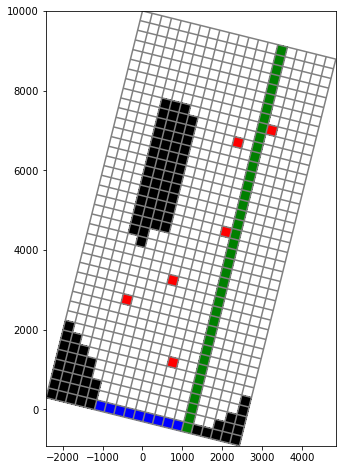

In [11]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=ml, rotation=-14)
quadmesh = modelmap.plot_ibound()
quadmesh = modelmap.plot_bc('RIV')
quadmesh = modelmap.plot_bc('WEL')
linecollection = modelmap.plot_grid()

/Users/JosephHughes/Development/flopy-git/flopy/utils/reference.py:404: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)
/Users/JosephHughes/Development/flopy-git/flopy/utils/reference.py:278: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)


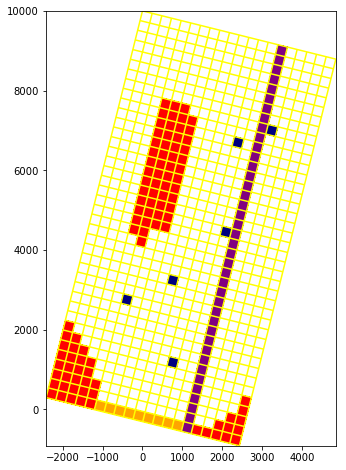

In [12]:
# Or we could change the colors!
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=ml, rotation=-14)
quadmesh = modelmap.plot_ibound(color_noflow='red', color_ch='orange')
quadmesh = modelmap.plot_bc('RIV', color='purple')
quadmesh = modelmap.plot_bc('WEL', color='navy')
linecollection = modelmap.plot_grid(colors='yellow')

The plot_bc() method can be used to plot a cross-section of boundary conditions.  Just like the plot_bc() method for ModelMap, the default bounday conditions can be changed in the method call.

Here, we plot the location of well cells in column 6.

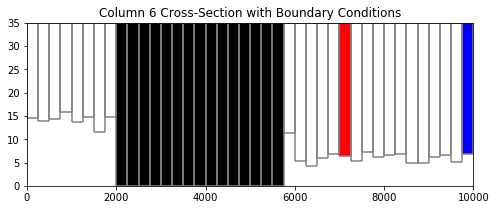

In [13]:
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(1, 1, 1)
modelxsect = flopy.plot.ModelCrossSection(model=ml, line={'Column': 5})
patches = modelxsect.plot_bc('WEL')
patches = modelxsect.plot_ibound()
linecollection = modelxsect.plot_grid()
t = ax.set_title('Column 6 Cross-Section with Boundary Conditions')

### Plotting an Array
ModelMap has a plot_array() method.  The plot_array() method will accept either a 2D or 3D array.  If a 3D array is passed, then the layer for the ModelMap object will be used (note that the ModelMap object can be created with a 'layer=' argument).

/Users/JosephHughes/Development/flopy-git/flopy/utils/reference.py:404: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)
/Users/JosephHughes/Development/flopy-git/flopy/utils/reference.py:278: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)


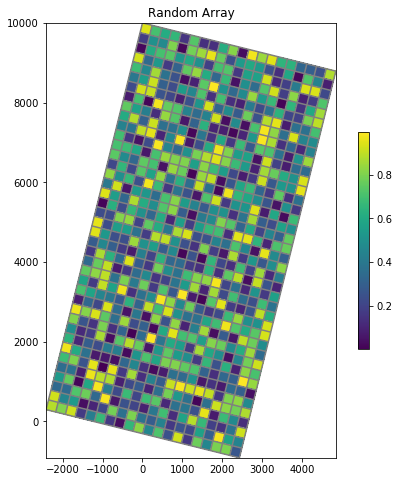

In [14]:
# Create a random array and plot it
a = np.random.random((ml.dis.nrow, ml.dis.ncol))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('Random Array')
modelmap = flopy.plot.ModelMap(model=ml, rotation=-14)
quadmesh = modelmap.plot_array(a)
linecollection = modelmap.plot_grid()
cb = plt.colorbar(quadmesh, shrink=0.5)

/Users/JosephHughes/Development/flopy-git/flopy/utils/reference.py:404: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)
/Users/JosephHughes/Development/flopy-git/flopy/utils/reference.py:278: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)


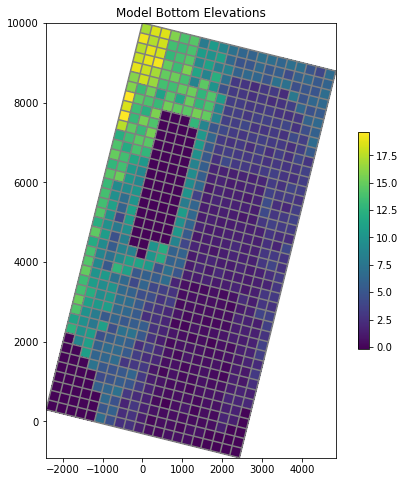

In [15]:
# Plot the model bottom array
a = ml.dis.botm.array

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('Model Bottom Elevations')
modelmap = flopy.plot.ModelMap(model=ml, rotation=-14)
quadmesh = modelmap.plot_array(a)
linecollection = modelmap.plot_grid()
cb = plt.colorbar(quadmesh, shrink=0.5)

ModelCrossSection also has a plot_array() method.  The plot_array() method accepts a 3D array.

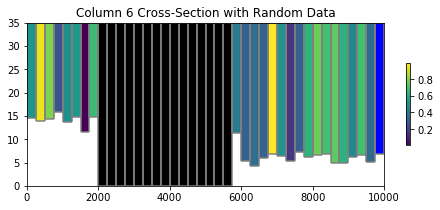

In [16]:
# Create a random array and plot it
a = np.random.random((ml.dis.nlay, ml.dis.nrow, ml.dis.ncol))

fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(1, 1, 1)
modelxsect = flopy.plot.ModelCrossSection(model=ml, line={'Column': 5})
csa = modelxsect.plot_array(a)
patches = modelxsect.plot_ibound()
linecollection = modelxsect.plot_grid()
t = ax.set_title('Column 6 Cross-Section with Random Data')
cb = plt.colorbar(csa, shrink=0.5)

### Contouring an Array
ModelMap also has a contour_array() method.  It also takes a 2D or 3D array and will contour the layer slice if 3D.

/Users/JosephHughes/Development/flopy-git/flopy/utils/reference.py:404: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)
/Users/JosephHughes/Development/flopy-git/flopy/utils/reference.py:278: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)


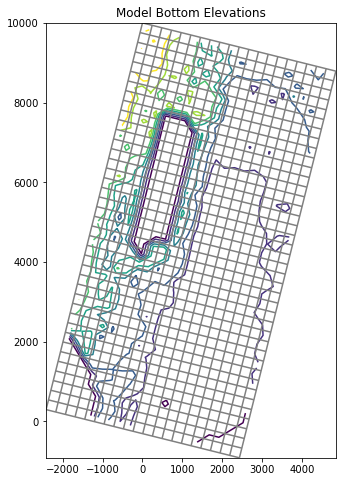

In [17]:
# Contour the model bottom array
a = ml.dis.botm.array

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('Model Bottom Elevations')
modelmap = flopy.plot.ModelMap(model=ml, rotation=-14)
contour_set = modelmap.contour_array(a)
linecollection = modelmap.plot_grid()

/Users/JosephHughes/Development/flopy-git/flopy/utils/reference.py:404: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)
/Users/JosephHughes/Development/flopy-git/flopy/utils/reference.py:278: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)


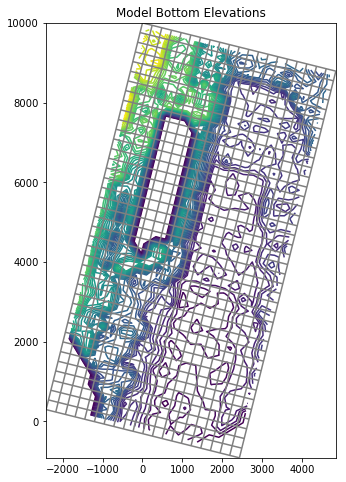

In [18]:
# The contour_array() method will take any keywords
# that can be used by the matplotlib.pyplot.contour
# function. So we can pass in levels, for example.
a = ml.dis.botm.array
levels = np.arange(0, 20, 0.5)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('Model Bottom Elevations')
modelmap = flopy.plot.ModelMap(model=ml, rotation=-14)
contour_set = modelmap.contour_array(a, levels=levels)
linecollection = modelmap.plot_grid()

### Plotting Heads
So this means that we can easily plot results from the simulation by extracting heads using flopy.utils.  Here we plot the simulated heads.

/Users/JosephHughes/Development/flopy-git/flopy/utils/reference.py:404: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)
/Users/JosephHughes/Development/flopy-git/flopy/utils/reference.py:278: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)


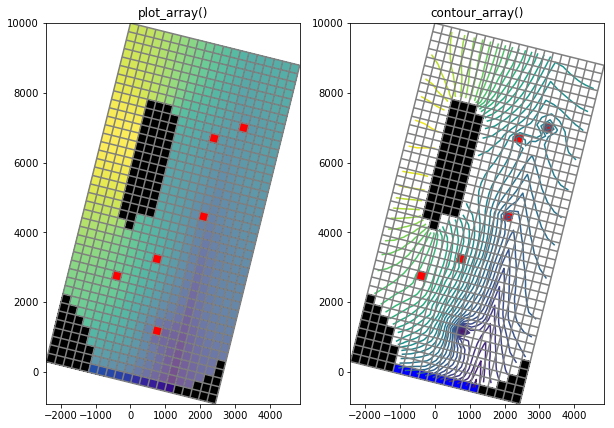

In [19]:
fname = os.path.join(modelpth, 'freyberg.hds')
hdobj = flopy.utils.HeadFile(fname)
head = hdobj.get_data()
levels = np.arange(10, 30, .5)

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 2, 1, aspect='equal')
ax.set_title('plot_array()')
modelmap = flopy.plot.ModelMap(model=ml, rotation=-14)
quadmesh = modelmap.plot_ibound()
quadmesh = modelmap.plot_array(head, masked_values=[999.], alpha=0.5)
modelmap.plot_bc("WEL")
linecollection = modelmap.plot_grid()

ax = fig.add_subplot(1, 2, 2, aspect='equal')
ax.set_title('contour_array()')
modelmap = flopy.plot.ModelMap(model=ml, rotation=-14)
quadmesh = modelmap.plot_ibound()
modelmap.plot_bc("WEL")
contour_set = modelmap.contour_array(head, masked_values=[999.], levels=levels)
linecollection = modelmap.plot_grid()

We can also plot simulated heads in cross-section. The head can be passed into the plot_array() and contour_array() to fix the top of the colored patch and contour lines at the top of the water table in each cell, respectively. The plot_surface() method can be used to plot the water-table elevation with the contour lines.

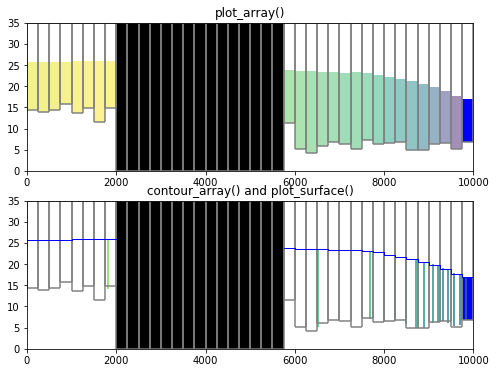

In [20]:
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(2, 1, 1)
ax.set_title('plot_array()')
modelxsect = flopy.plot.ModelCrossSection(model=ml, line={'Column': 5})
csa = modelxsect.plot_array(head, masked_values=[999.], head=head, alpha=0.5)
patches = modelxsect.plot_ibound(head=head)
linecollection = modelxsect.plot_grid()

ax = fig.add_subplot(2, 1, 2)
ax.set_title('contour_array() and plot_surface()')
modelxsect = flopy.plot.ModelCrossSection(model=ml, line={'Column': 5})
ct = modelxsect.contour_array(head, masked_values=[999.], head=head, levels=levels)
patches = modelxsect.plot_ibound(head=head)
wt = modelxsect.plot_surface(head, masked_values=[999.], color='blue', lw=1)
linecollection = modelxsect.plot_grid()

### Plotting Discharge Vectors
ModelMap has a plot_discharge() method, which takes the 'FLOW RIGHT FACE' and 'FLOW FRONT FACE' arrays, which can be written by MODFLOW to the cell by cell flow file.  These array can be extracted from the cell by cell flow file using the flopy.utils.CellBudgetFile object as shown below.  Once they are extracted, they can be passed to the plot_discharge() method.  Note that plot_discharge() also takes the head array as an argument.  The head array is used by plot_discharge() to convert the volumetric discharge in dimensions of $L^3/T$ to specific discharge in dimensions of $L/T$.

/Users/JosephHughes/Development/flopy-git/flopy/utils/reference.py:404: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)
/Users/JosephHughes/Development/flopy-git/flopy/utils/reference.py:278: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)


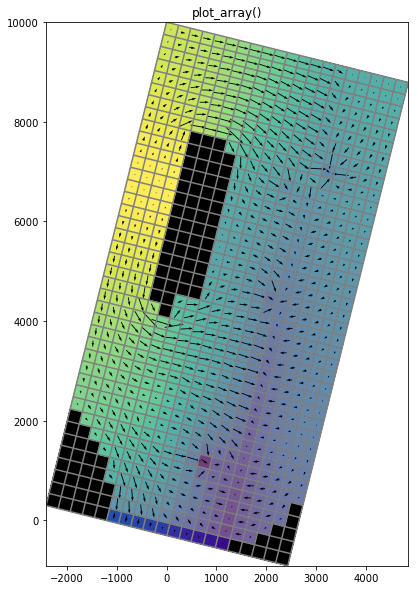

In [21]:
fname = os.path.join(modelpth, 'freyberg.cbc')
cbb = flopy.utils.CellBudgetFile(fname)
frf = cbb.get_data(text='FLOW RIGHT FACE')[0]
fff = cbb.get_data(text='FLOW FRONT FACE')[0]

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('plot_array()')
modelmap = flopy.plot.ModelMap(model=ml, rotation=-14)
quadmesh = modelmap.plot_ibound()
quadmesh = modelmap.plot_array(head, masked_values=[999.], alpha=0.5)
quiver = modelmap.plot_discharge(frf, fff, head=head)
linecollection = modelmap.plot_grid()

ModelCrossSection has a plot_discharge() method, which takes the 'FLOW RIGHT FACE', 'FLOW FRONT FACE', and 'FLOW LOWER FACE' arrays, which can be written by MODFLOW to the cell by cell flow file.  These array can be extracted from the cell by cell flow file using the flopy.utils.CellBudgetFile object as shown below.  Once they are extracted, they can be passed to the plot_discharge() method.  Note that plot_discharge() also takes the head array as an argument.  The head array is used by plot_discharge() to convert the volumetric flow in dimensions of $L^3/T$ to specific discharge in dimensions of $L/T$ and to plot the specific discharge in the center of each saturated cell. For this problem, there is no 'FLOW LOWER FACE' array since the Freyberg Model is a one layer model.

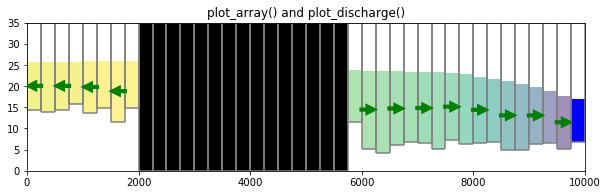

In [22]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(2, 1, 1)
ax.set_title('plot_array() and plot_discharge()')
modelxsect = flopy.plot.ModelCrossSection(model=ml, ax=ax, line={'Column': 5})
csa = modelxsect.plot_array(head, masked_values=[999.], head=head, alpha=0.5)
linecollection = modelxsect.plot_grid()
quiver = modelxsect.plot_discharge(frf, fff, head=head, 
                                   hstep=2, normalize=True, color='green', 
                                   scale=30, headwidth=3, headlength=3, headaxislength=3,
                                   zorder=10)
patches = modelxsect.plot_ibound(head=head)

### Plotting MODPATH endpoints and pathlines
ModelMap has a `plot_endpoint()` and `plot_pathline()` method, which takes MODPATH endpoint and pathline data and plots them on the map object. Here we load the endpoint and pathline data and plot them on the head and discharge data previously plotted. Pathlines are shown for all times less than or equal to 200 years. Recahrge capture zone data for all of the pumping wells are plotted as circle markers colored by travel time.

/Users/JosephHughes/Development/flopy-git/flopy/utils/reference.py:404: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)
/Users/JosephHughes/Development/flopy-git/flopy/utils/reference.py:278: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)


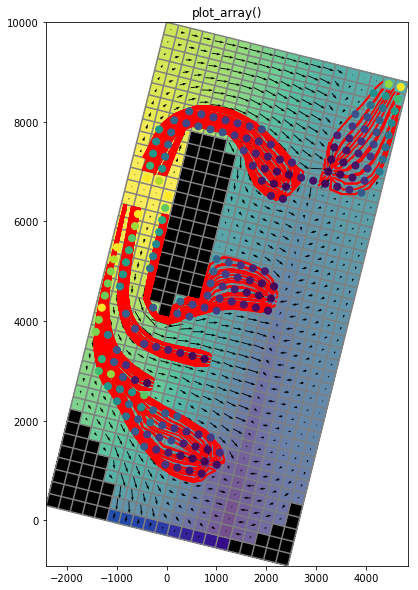

In [23]:
# load the endpoint data
endfile = os.path.join(modelpth, mp.sim.endpoint_file)
endobj = flopy.utils.EndpointFile(endfile)
ept = endobj.get_alldata()

# load the pathline data
pthfile = os.path.join(modelpth, mpp.sim.pathline_file)
pthobj = flopy.utils.PathlineFile(pthfile)
plines = pthobj.get_alldata()

# plot the data
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('plot_array()')
modelmap = flopy.plot.ModelMap(model=ml, rotation=-14)
quadmesh = modelmap.plot_ibound()
quadmesh = modelmap.plot_array(head, masked_values=[999.], alpha=0.5)
quiver = modelmap.plot_discharge(frf, fff, head=head)
linecollection = modelmap.plot_grid()
for d in ml.wel.stress_period_data[0]:
    modelmap.plot_endpoint(ept, direction='starting', selection_direction='ending', selection=(d[0], d[1], d[2]), zorder=100)

# construct maximum travel time to plot (200 years - MODFLOW time unit is seconds)
travel_time_max = 200. * 365.25 * 24. * 60. * 60. 
ctt = '<={}'.format(travel_time_max)

# plot the pathlines
modelmap.plot_pathline(plines, layer='all', colors='red', travel_time=ctt);

### Plotting a Shapefile
ModelMap has a plot_shapefile() method that can be used to quickly plot a shapefile on your map.  In order to use the plot_shapefile() method, you must be able to "import shapely".  Shapely is installed as part of the pyshp package.

The plotting function for shape files is located in the flopy.plot.plotutil module and is called plot_shapefile().  This function is called from the ModelMap plot_shapefile() method.  The plot_shapefile() function can plot points, lines, and polygons and will return a patch_collection of objects from the shapefile.  For a shapefile of polygons, the plot_shapefile() function will try to plot and fill them all using a different color.  For a shapefile of points, you may need to specify a radius, in model units, in order for the circles to show up properly.

The shapefile must be in the same units as the ModelMap object in order for it to overlay correctly on the plot.  The plot_shapefile() method and function do not use any of the projection information that may be stored with the shapefile.  If you set xul, yul, and rotation for the modelmap object below, you will see that the grid will no longer overlay correctly with the shapefile.

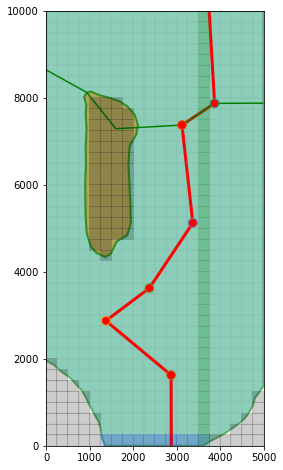

In [24]:
# Setup the figure and modelmap. Show a very faint map of ibound and 
# model grid by specifying a transparency alpha value.
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=ml,ax=ax)

# Plot a shapefile of 
shp = os.path.join(loadpth, 'gis', 'bedrock_outcrop_hole')
patch_collection = modelmap.plot_shapefile(shp, #facecolor='none', 
                                           edgecolor='green', linewidths=2, alpha=0.5)
# Plot a shapefile of a cross-section line
shp = os.path.join(loadpth, 'gis', 'cross_section')
patch_collection = modelmap.plot_shapefile(shp, radius=0, lw=[3, 1.5], edgecolor=['red', 'green'], facecolor='None')

# Plot a shapefile of well locations
shp = os.path.join(loadpth, 'gis', 'wells_locations')
patch_collection = modelmap.plot_shapefile(shp, radius=100, facecolor='red')

# Plot the grid and boundary conditions over the top
quadmesh = modelmap.plot_ibound(alpha = 0.1)
quadmesh = modelmap.plot_bc('RIV', alpha=0.1)
linecollection = modelmap.plot_grid(alpha=0.1)

A shapefile can be used to define the vertices for a instance of ModelCrossSection class. The function shapefile_get_vertices() in plot.plotutil will return a list of vertices for each polyline in a shapefile. The cross-section line list can be iterated over to create multiple cross-sections.

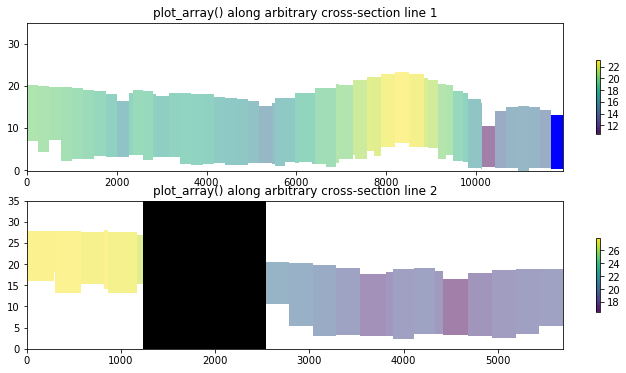

In [25]:
# get the vertices for cross-section lines in a shapefile
lines = flopy.plot.plotutil.shapefile_get_vertices(os.path.join(loadpth, 'gis', 'cross_section'))
# plot each cross-section
fig = plt.figure(figsize=(12, 6))
for idx, line in enumerate(lines):
    ax = fig.add_subplot(2, 1, idx+1)
    ax.set_title('plot_array() along arbitrary cross-section line {}'.format(idx+1))
    modelxsect = flopy.plot.ModelCrossSection(model=ml, line={'line': line})
    csa = modelxsect.plot_array(head, masked_values=[999.], head=head, alpha=0.5)
    patches = modelxsect.plot_ibound(head=head)
    cb = fig.colorbar(csa, ax=ax, shrink=0.5)

Although the ModelMap plot_shapefile() method does not consider projection information when plotting maps, it can be used to plot shapefiles when a ModelMap instance is rotated and offset into geographic coordinates. The same shapefiles plotted above (but in geographic coordinates rather than model coordinates) are plotted on the rotated model grid. The offset from model coordinates to geographic coordinates relative to the upper left corner are x=0, y=10,000 and the rotation angle is 14$^{\circ}$.

/Users/JosephHughes/Development/flopy-git/flopy/utils/reference.py:404: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)
/Users/JosephHughes/Development/flopy-git/flopy/utils/reference.py:278: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)


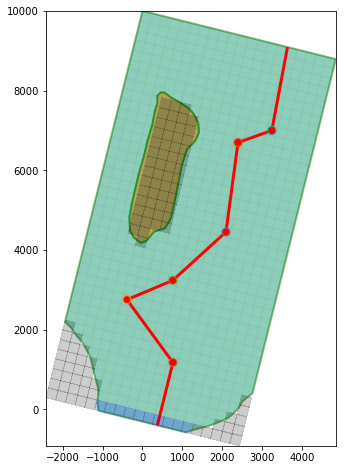

In [26]:
# Setup the figure and modelmap. Show a very faint map of ibound and 
# model grid by specifying a transparency alpha value.
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=ml, rotation = -14, xul = 0, yul =10000)

# Plot a shapefile of 
shp = os.path.join(loadpth, 'gis', 'bedrock_outcrop_hole_rotate14')
patch_collection = modelmap.plot_shapefile(shp, #facecolor='none', 
                                           edgecolor='green', linewidths=2, alpha=0.5)
# Plot a shapefile of a cross-section line
shp = os.path.join(loadpth, 'gis', 'cross_section_rotate14')
patch_collection = modelmap.plot_shapefile(shp, radius=0, lw=3, edgecolor='red', facecolor='None')

# Plot a shapefile of well locations
shp = os.path.join(loadpth, 'gis', 'wells_locations_rotate14')
patch_collection = modelmap.plot_shapefile(shp, radius=100, facecolor='red')

# Plot the grid and boundary conditions over the top
quadmesh = modelmap.plot_ibound(alpha = 0.1)
linecollection = modelmap.plot_grid(alpha=0.1);

A projected shapefile can also be used to define the vertices for a instance of ModelCrossSection class. Just the first cross-section line is included in the shapefile in geographic coordinates (cross_section_rotate14). Similar to the unrotated cross-section example, a ModelCrossSection instance is created but the rotation angle (14$^{\circ}$) is passed into the object.

/Users/JosephHughes/Development/flopy-git/flopy/utils/reference.py:278: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)


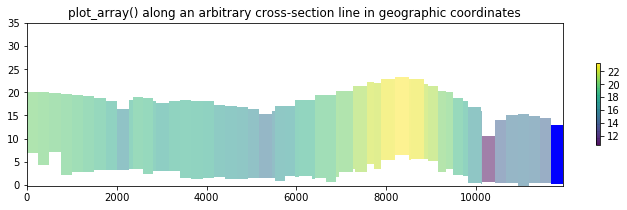

In [27]:
# get the vertices for cross-section lines in a shapefile in geographic coordinates
line = flopy.plot.plotutil.shapefile_get_vertices(os.path.join(loadpth, 'gis', 'cross_section_rotate14'))
# plot the cross-section
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('plot_array() along an arbitrary cross-section line in geographic coordinates')
modelxsect = flopy.plot.ModelCrossSection(model=ml, line={'line': line[0]}, rotation=-14)
csa = modelxsect.plot_array(head, masked_values=[999.], head=head, alpha=0.5)
patches = modelxsect.plot_ibound(head=head)
cb = fig.colorbar(csa, ax=ax, shrink=0.5)

## Summary

This notebook demonstrates some of the plotting functionality available with flopy.  Although not described here, the plotting functionality tries to be general by passing keyword arguments passed to the ModelMap and ModelCrossSection methods down into the matplot.pyplot routines that do the actual plotting.  For those looking to customize these plots, it may be necessary to search for the available keywords by understanding the types of objects that are created by the ModelMap and ModelCrossSection methods.  The ModelMap and ModelCrossSection methods return these matplotlib.collections objects so that they could be fine-tuned later in the script before plotting.

Hope this gets you started!